In [11]:
import healpy as hp
import pylab as pl
import numpy as np
import os 

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap,construct_beammap, coordinates_on_grid,gauss2d

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import waferts_add_diffbeam
from s4cmb.systematics import get_kernel_coefficients,get_kernel_coefficients_sumdiff
from s4cmb.systematics import inject_beam_ellipticity
from s4cmb.systematics import derivs
from s4cmb.systematics import modify_beam_offsets

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

# gets rid of warning when plotting beams
np.seterr(divide='ignore',invalid='ignore')

#set s4cmb path
for k in os.environ.keys():
    if 's4cmb' in k.lower():
        s4cmbpath=os.environ['s4cmbPATH']


In [15]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

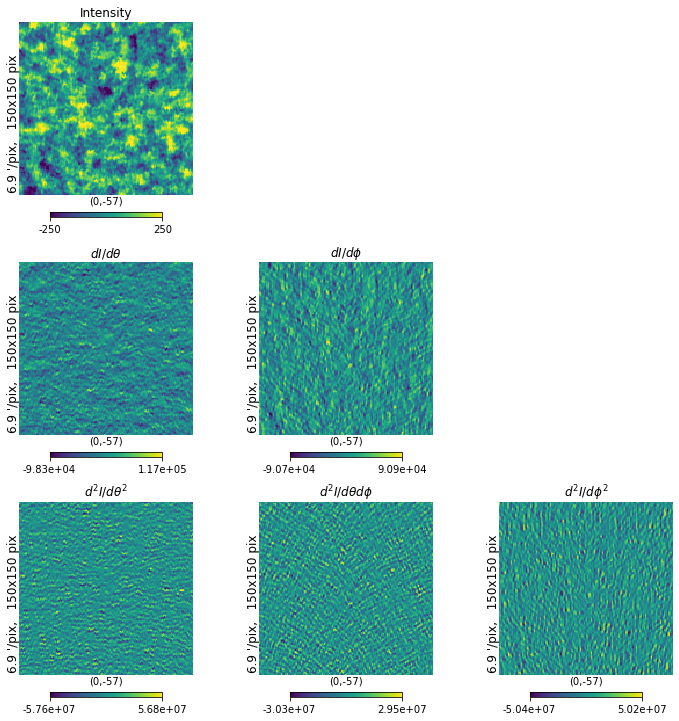

In [12]:

## Input maps
nside = 512
path_to_cls = os.path.join(s4cmbpath,'s4cmb/data/test_data_set_lensedCls.dat')
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, compute_derivatives=True,
                        no_ileak=False, no_quleak=False)

xsize=150
reso=6.9

pl.figure(figsize=(10, 10))
hp.gnomview(sky_in.I, rot=[0, -57], 
            xsize=xsize, reso=reso,
            title='Intensity',
            min=-250, max=250, sub=331)
hp.gnomview(sky_in.dIdt, rot=[0, -57], 
            title='$dI/d\\theta$',
            xsize=xsize, reso=reso, sub=334)
hp.gnomview(sky_in.dIdp, rot=[0, -57], 
            title='$dI/d\\phi$',
            xsize=xsize, reso=reso, sub=335)
hp.gnomview(sky_in.d2Id2t, rot=[0, -57], 
            title='$d^2I/d\\theta^2$',
            xsize=xsize, reso=reso, sub=337)
hp.gnomview(sky_in.d2Idpdt, rot=[0, -57], 
            title='$d^2I/d\\theta d\\phi$',
            xsize=xsize, reso=reso, sub=338)
hp.gnomview(sky_in.d2Id2p, rot=[0, -57], 
            title='$d^2I/d\\phi^2$',
            xsize=xsize, reso=reso, sub=339)
pl.show()

In [13]:
## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn=os.path.join(s4cmbpath,'s4cmb/data/ut1utc.ephem'), 
                        language='fortran')
scan.run()

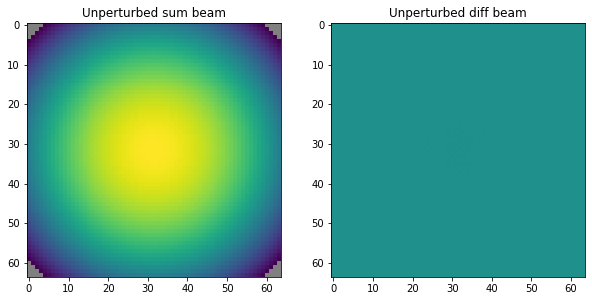

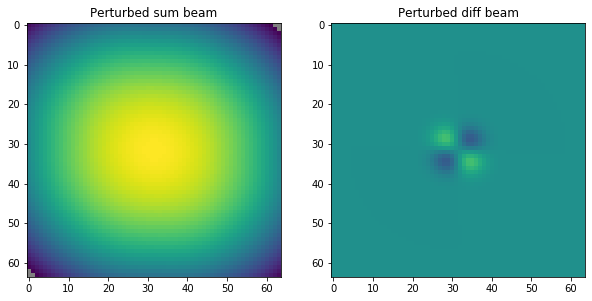

In [16]:
## Just for visualisation
fig, ax = pl.subplots(1, 2, figsize=(10, 5))
pix_size = 0.5 / 60. * np.pi / 180.
nx = 64

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
ax[0].imshow(np.log10(summap))#, vmin=0, vmax=1)
ax[0].set_title('Unperturbed sum beam')
ax[1].imshow(diffmap, vmin=-0.2, vmax=0.2)
ax[1].set_title('Unperturbed diff beam')
pl.show()


## Generate beam ellipticity (20% \pm 5%)
sig_1, sig_2, ellip_ang = inject_beam_ellipticity(
    inst.beam_model.sig_1[0], 10, 5, 
    inst.focal_plane.nbolometer, 
    do_diffbeamellipticity=True)



inst.beam_model.sig_1 = sig_1
inst.beam_model.sig_2 = sig_2
inst.beam_model.ellip_ang = ellip_ang

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
fig, ax = pl.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.log10(summap))#, vmin=0, vmax=1)
ax[0].set_title('Perturbed sum beam')
ax[1].imshow(diffmap, vmin=-0.1, vmax=0.1)
ax[1].set_title('Perturbed diff beam')

pl.show()

In [17]:
npair = inst.focal_plane.npair
pair_list = np.reshape(
inst.focal_plane.bolo_index_in_fp, (npair, 2))

## For visualisation
Ktot = []
Ktot_sum=[]
Ktot_diff=[]
## Pre compute leakage runs pair-by-pair 
for pair in tqdm(pair_list):
    
    ## Compute beam kernel coefficients
    K = get_kernel_coefficients(inst.beam_model, [pair],nx=200)
    Ktot.append(K)
    Ksumdiff=get_kernel_coefficients_sumdiff(inst.beam_model, [pair], inst.beam_model.fwhm,nx=200)
    Ktot_diff.append(Ksumdiff[0])
    Ktot_sum.append(Ksumdiff[1])


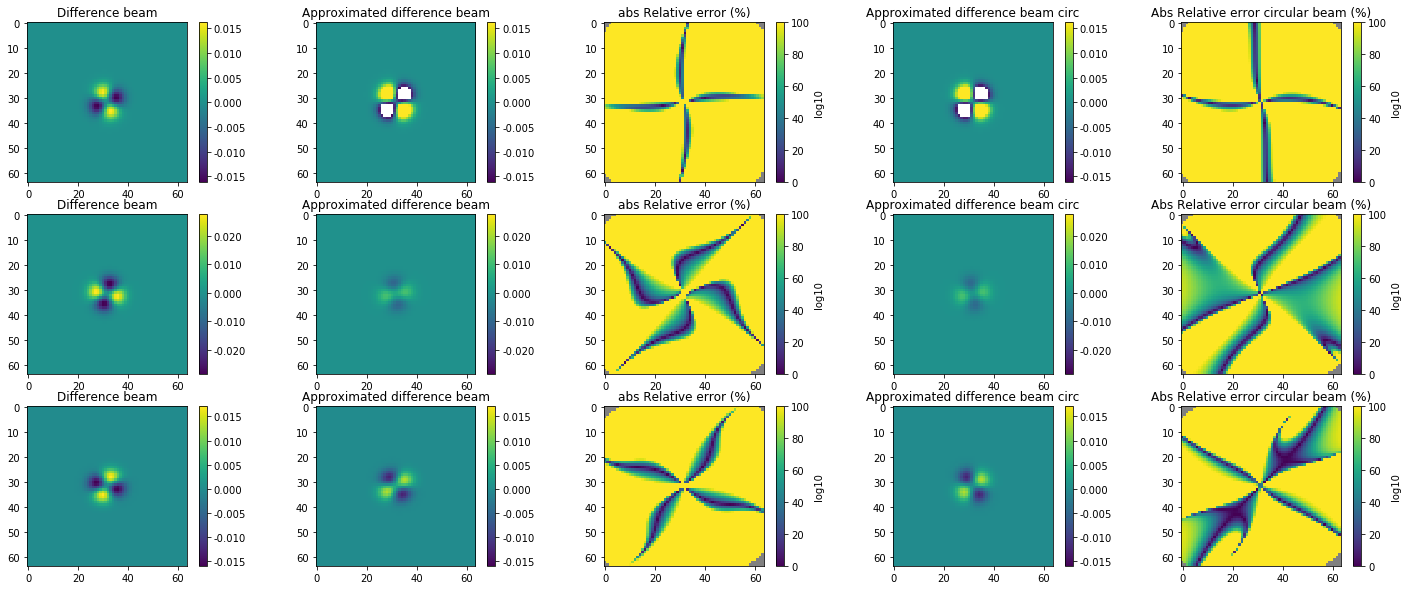

In [48]:
# default pix size for leakage calculation is 1/7 of FWHM
pix_size = inst.beam_model.fwhm / 7. / 60. * np.pi / 180.
nx = 64

#compute circular beam and its derivative to compare expansions on sumbeam and circular beam approximation
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam, pix_size)
der_circ = der_circ.reshape((6, circ_beam.shape[0] * circ_beam.shape[1]))
    
fig,ax = pl.subplots(3,5,figsize=(25,10))
for i in range(3):
    detid = 2*i+10 # pick random detectors in the focalplane
    
    ## Compute sum and diff beam map for the chosen pair
    summap, diffmap = construct_beammap(inst.beam_model, detid, detid+1, nx, pix_size)
    
    ## Compute derivative of sumbeam 
    der = derivs(summap, pix_size)
    der = der.reshape((6, summap.shape[0] * summap.shape[1]))
    
    ## Compute approximate beam using expansion on derivatives on the sum beam 
    ## and relative error w.r.t. to the true diffbeam    
    diffmap_approx = np.dot(Ktot[i][0], der).reshape((nx, nx))
    rel=(diffmap - diffmap_approx)/diffmap*100

    ## Compute approximate diffbeam using expansion on derivatives on the Gaussian circular beam
    ## and relative error w.r.t. to the true diffbeam
    diffmap_approx2 = np.dot(Ktot_diff[i][0], der_circ).reshape((nx, nx))
    rel2=(diffmap - diffmap_approx2)/diffmap*100
    
    obj1 = ax[i, 0].imshow(diffmap, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 0].set_title('Difference beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.3f')
    
    obj2 = ax[i, 1].imshow(diffmap_approx, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 1].set_title('Approximated difference beam')
    fig.colorbar(obj2, ax=ax[i, 1],orientation='vertical', shrink=1., format='%.3f')
    
    obj3 = ax[i, 2].imshow(np.abs(rel),vmin=0, vmax=100, aspect='equal')
    ax[i,2].set_title('abs Relative error (%)')
    fig.colorbar(obj3, ax=ax[i, 2],orientation='vertical', shrink=1., format='%.0f',label='log10')
    
    obj4 = ax[i, 3].imshow(diffmap_approx2, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 3].set_title('Approximated difference beam circ')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.3f')
    
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Relative error circular beam (%)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='log10')
    
    # debug printout with ratio of sum of relative errors and ellipticities
    #print(np.sum(np.abs(rel2[(rel2==rel2) & np.isfinite(rel2)])**2)/np.sum(np.abs(rel[(rel==rel) & np.isfinite(rel)]))**2)
    #et=(inst.beam_model.sig_1[detid]-inst.beam_model.sig_2[detid])/(inst.beam_model.sig_1[detid]+inst.beam_model.sig_2[detid])
    #eb=(inst.beam_model.sig_1[detid+1]-inst.beam_model.sig_2[detid+1])/(inst.beam_model.sig_1[detid+1]+inst.beam_model.sig_2[detid+1])
    #print(et,eb)
pl.show()


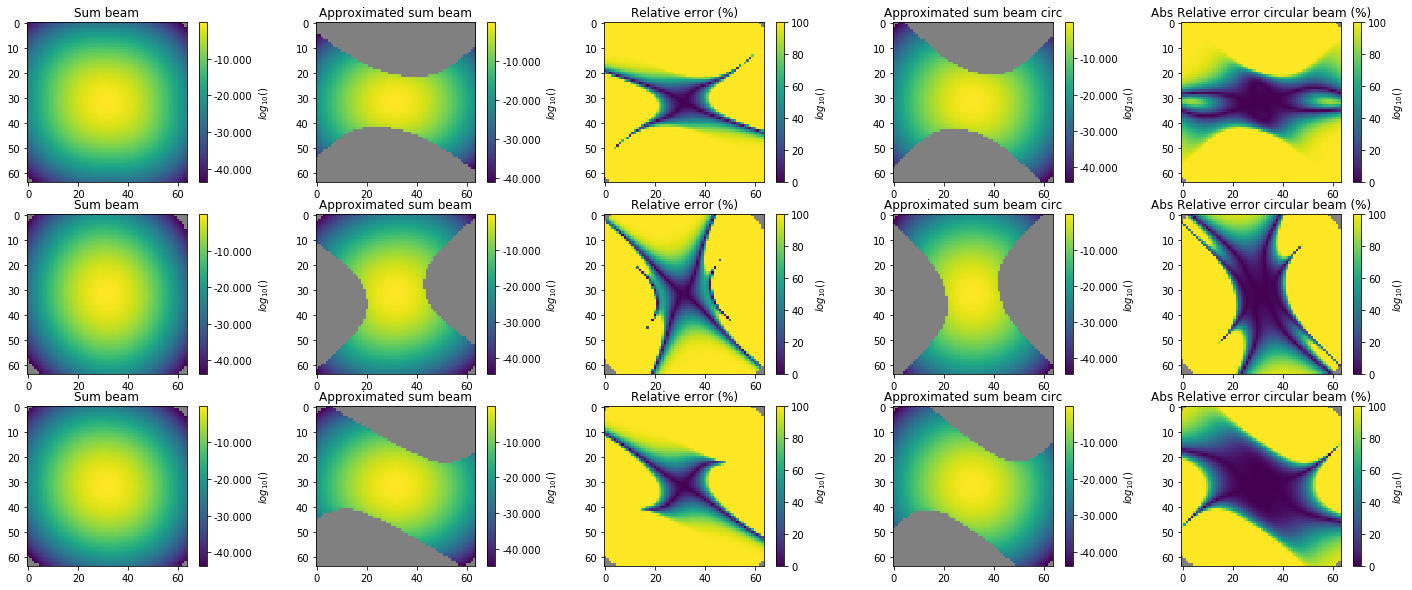

In [47]:
#same as above for the sum beam 
pix_size = 3.5 / 7. / 60. * np.pi / 180.
np.seterr(divide='ignore',invalid='ignore')
fig,ax = pl.subplots(3,5,figsize=(25,10))

for i in range(3):
    summap, diffmap = construct_beammap(inst.beam_model, 2*i, 2*i+1, nx, pix_size)
    #print(Ktot_sum[i][0])
    #print(Ktot_diff[i][0])
    #print(Ktot[i][0])
    
    ## Compute approximate sum beam using expansion on derivatives of the sum beam 
    ## and relative error w.r.t. to the true sumbeam    
    summap_approx = np.dot(Ktot_sum[i][0], der).reshape((nx, nx))
    rel=(summap - summap_approx)/summap*100    
    ## Compute approximate sum beam using expansion on derivatives of the circula Gaussian beam
    ## and relative error w.r.t. to the true sumbeam        
    summap_approx2 = np.dot(Ktot_sum[i][0], der_circ).reshape((nx, nx))
    rel2=(summap - summap_approx2)/summap*100    
    
    obj1 = ax[i, 0].imshow(np.log10(summap), aspect='equal')
    ax[i, 0].set_title('Sum beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    obj2 = ax[i, 1].imshow(
    #    summap_approx, vmin=np.min(summap), vmax=np.max(summap), aspect='equal')
         np.log10(summap_approx), aspect='equal')
    ax[i, 1].set_title('Approximated sum beam')
    fig.colorbar(obj2, ax=ax[i, 1], orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    obj3 = ax[i, 2].imshow(np.abs(rel), vmin=0,vmax=100,aspect='equal')
    ax[i,2].set_title('Relative error (%)')
    fig.colorbar(obj3, ax=ax[i, 2], orientation='vertical', shrink=1., format='%.0f',label='log10')

    obj4 = ax[i, 3].imshow(np.log10(summap_approx2),aspect='equal')#, vmin=np.min(diffmap), vmax=np.max(diffmap), 
    ax[i, 3].set_title('Approximated sum beam circ')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Relative error circular beam (%)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='log10')    

pl.show()

In [7]:
# set parameters for Noiseless simulations
array_noise_level = 0.0
state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

#define plotting routines

def plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=None):
    if xsize_leak is None:
        xsize_leak = xsize
        
    fig = pl.figure(figsize=(10, 15))

    nhit = partial2full(sky.nhit, sky.obspix, sky.nside, fill_with=0.0)
    
    ## Temperature
    sky_out = partial2full(sky.get_I(),sky.obspix,sky.nside, fill_with=0.0)

    mask = nhit < 1
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input I', notext=True, min=-250, max=250)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output I', notext=True, min=-250, max=250)
    hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=333, 
            title='Difference', notext=True)

    ## Stokes Q
    sky_out = partial2full(sky.get_QU()[0], sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            title='Input Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            title='Output Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=336, 
            notext=True, title='Difference', min=-0.15, max=0.15)

    ## Stokes U
    sky_out = partial2full(sky.get_QU()[1],sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            title='Input U',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            title='Output U',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=339, 
            title='Difference', notext=True, min=-0.15, max=0.15)
    pl.show()
    return

def plot_coverage(sky, xsize=700,reso=6.9):
    fig = pl.figure(figsize=(10, 5))

    nhit = partial2full(sky.nhit, sky.obspix, sky.nside, fill_with=0.0)
    det = partial2full( (sky.cc*sky.ss) - (sky.cs**2), sky.obspix, sky.nside, fill_with=0.0)
    cs = partial2full(sky.cs, sky.obspix, sky.nside, fill_with=0.0)
    
    
    ## Temperature
    sky_out = partial2full(sky.get_I(),sky.obspix,sky.nside, fill_with=0.0)

    mask = nhit < 1
    nhit[mask] = np.nan
    det[mask] = np.nan
    cs[mask] = np.nan
    
    hp.gnomview(nhit, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=131, 
            title='Nhits', notext=True)
    hp.gnomview(det, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=132, 
            title='Polarization block determinant', notext=True,)
    hp.gnomview(cs, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=133, 
            title='$<cos2\psi sin2\psi>$', notext=True)   
    pl.show()
    return

## Mapmaking ## 

The following examples show how to compute leakages due to differential ellipticity properties in the maps.Examples incude :
* T->P leakage due to differential beam properties including or not monopole leakage
* T->T, P->P distortion due to differential beam parameters (including or not the power mismatch (monopole component) due to differential 

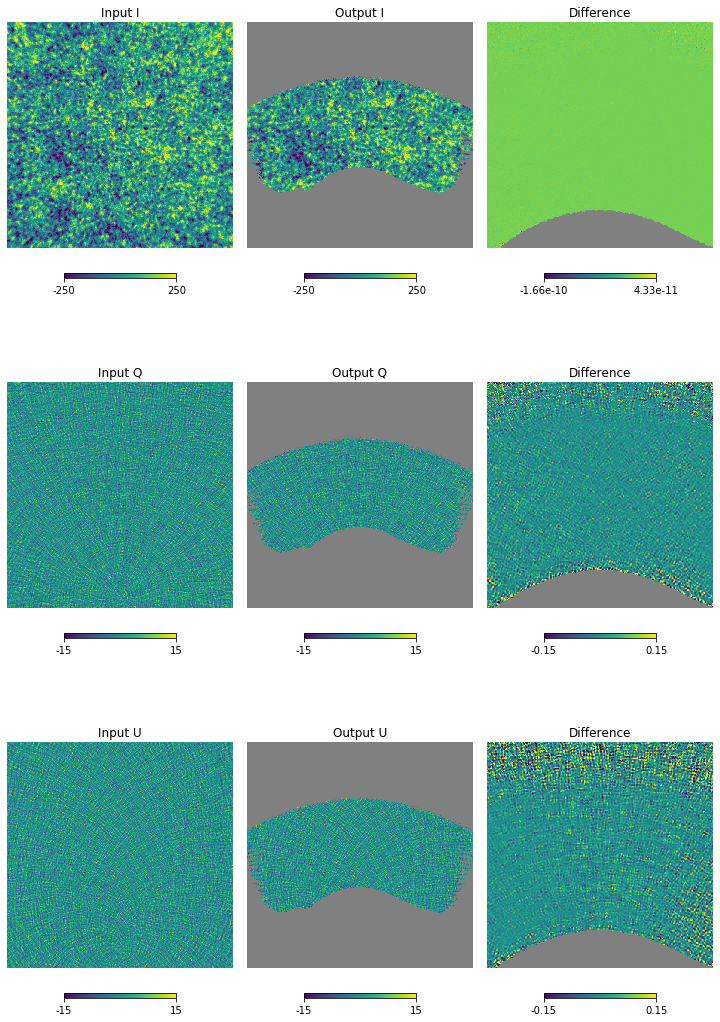

In [82]:
# This example includes only T->P leakage excluding monopole leakage 
## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
    
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients
        ## the commented line expand the leakage over the derivatives
        ## of the perturbed beam. This notebook uses by default the 
        ## expansion on the derivatives of the circular beam used for the
        ## convolution of the input map.
        #Kdiff = get_kernel_coefficients(inst.beam_model, [pair])
        Kdiff,Ksum = get_kernel_coefficients_sumdiff(inst.beam_model, [pair],
                inst.beam_model.fwhm)
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Kdiff,
            pairlist=pair, 
            spins='012',kernel_type='diff_nomonopole')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)
        
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=300)

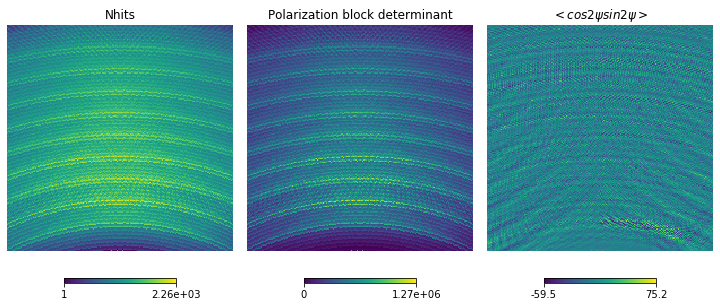

In [84]:
#Since the residual depends on the cross-linkning of the pixels, you can display the cross linking using this function
# A low polarization block determinant means pixels are badly condition and we expect higher residual leakage
# For badly observed pixels, Q and U are correlated and a measurement of this correlation is given by the
# amplitude of the off diagonal term in the polarization block, i.e. <cos2\psi sin2\psi>, where <> indicates the
# average over samples and psi the polarization angle

plot_coverage(sky,200)



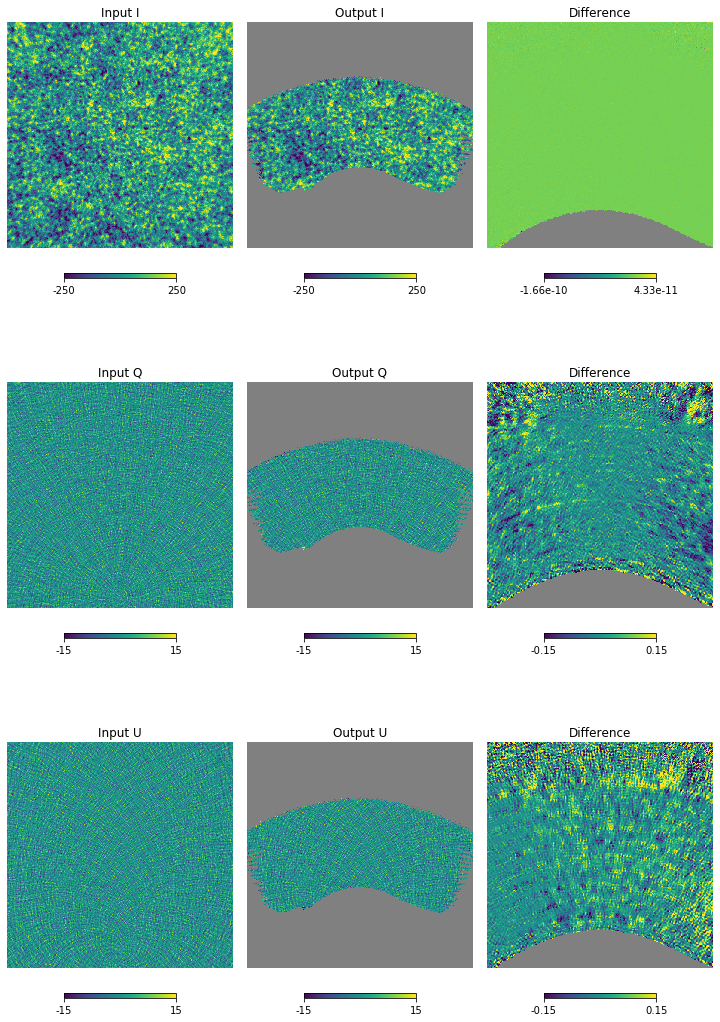

In [85]:

# You can add the monopole leakage removing the _nomonopole string in the kernel definition. You can see
# that the leakage now is dominated by a structure that ressembles more the T map while the T maps itself
# is still unaffected.


## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
    
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        Kdiff,Ksum = get_kernel_coefficients_sumdiff(inst.beam_model, [pair],
                inst.beam_model.fwhm)
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Kdiff,
            pairlist=pair, 
            spins='012',kernel_type='diff')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)
        
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=300)

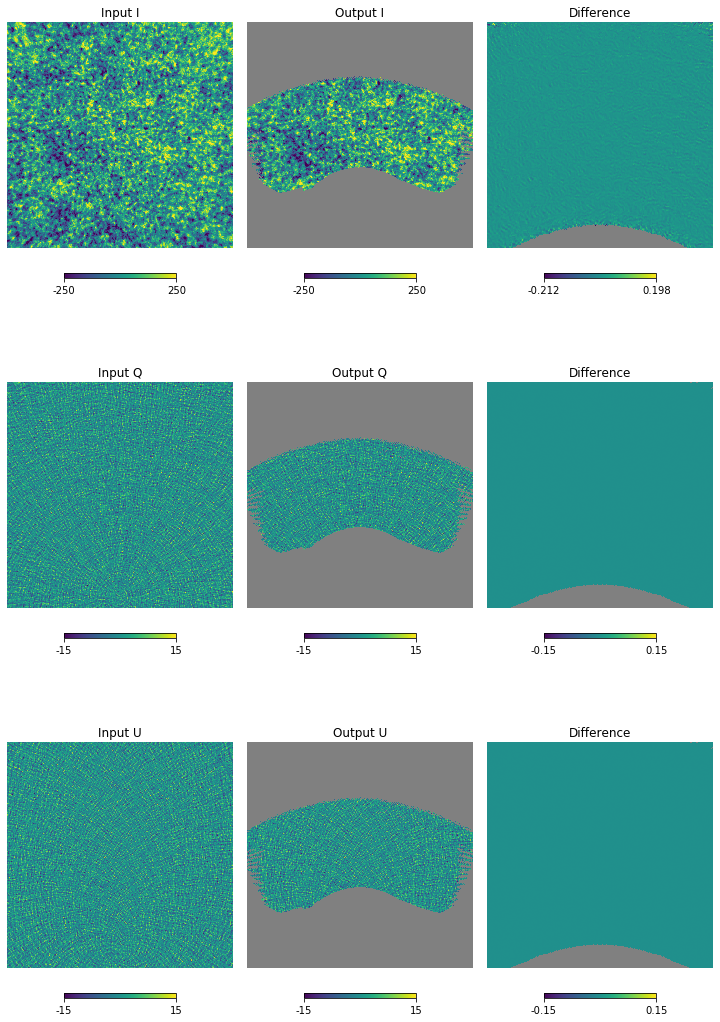

In [87]:
# in this example we inject sum leakage due do beam distortions on temperature only. As done above you can remove the 
# _nomonopole part to include the monopole part


## Loop over scans
for CESnumber in range(scan.nces):
#for CESnumber in range(1):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects need to be constructed only for the observed pixel in the 
        # field. 
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients expandend on the circular beam approximation
        Kdiff,Ksum = get_kernel_coefficients_sumdiff(inst.beam_model,[pair],inst.beam_model.fwhm)
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ksum,
            pairlist=pair, 
            spins='012',kernel_type='sum_nomonopole')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=250)

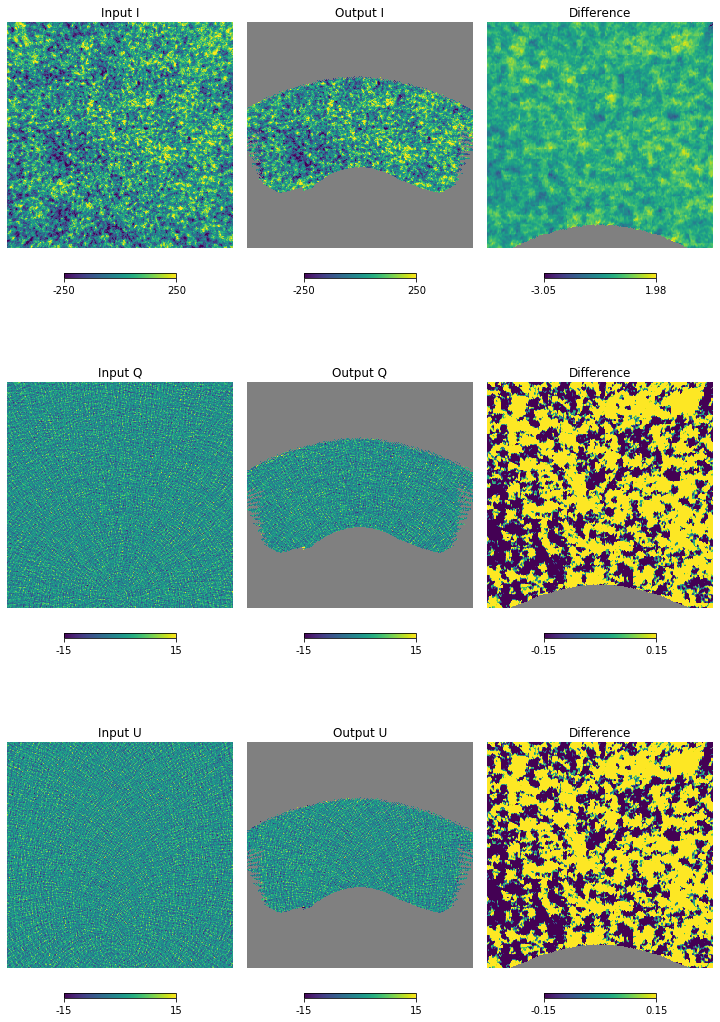

In [91]:
# in this cell we make an example including polarization and monopole leakage. Note you can specify 
# different type of spin terms to be included in temperature and polarization wiht the spins_pol keyword.
# with sum leakage you will inlude I->I (and P->P if you provide polarization derivatives).
# with diff leakage you will inlude I->P (and P->I if you provide polarization derivatives).

for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects need to be constructed only for the observed pixel in the 
        # field. 
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
        
        # ATTENTION polarization derivatives are not supported by healpix. For the purpose of this
        # toy example we assumed the are 1/10 of the intensity derivatives.
        q_derivatives = [i/10 for i in intensity_derivatives]
        u_derivatives = q_derivatives
        pol_derivatives=[q_derivatives,u_derivatives]
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        Kdiff,K = get_kernel_coefficients_sumdiff(inst.beam_model, [pair],inst.beam_model.fwhm)
        
        ## Get spurious signal from beam mismatch
        ## Usign is useful only if flat sky simulations are carried out and it takes
        ## care of injecting the U leakage witht he correct sign as it differs from the 
        ## Healpix convention. Same syntax applies for diff kernels to inject P_I leakage
        
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=K,
            pairlist=pair, 
            spins='012',kernel_type='sum',pol_derivatives=[intensity_derivatives,intensity_derivatives],pol_angle=tod.pol_angs,Usign=tod.Usign)
        
        ## Project TOD to maps
        tod.tod2map(d, sky)

plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=250)        

In [ ]:
# in this specific example we show a problem appearing if you do not inject the correct derivative vector but the 
# full sky maps instead.
# we also show an example of the use of the spins_pol keyword, rerunning a similar example as above but removing the 
# monopole component for polarization which is the responsible of the majority of the leakage. 

In [ ]:
# in this specific example we show a problem appearing if you do not inject the correct derivative vector but the 
# full sky maps instead.
# we also show an example of the use of the spins_pol keyword, rerunning a similar example as above but removing the 
# monopole component for polarization which is the responsible of the majority of the leakage. 

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects need to be constructed only for the observed pixel in the 
        # field. 
        intensity_derivatives = np.array(
            [sky_in.I, sky_in.dIdt, sky_in.dIdp, 
             sky_in.d2Idpdt, sky_in.d2Id2t, sky_in.d2Id2p])
        
        # ATTENTION polarization derivatives are not supported by healpix. For the purpose of this
        # toy example we assumed the are 1/10 of the intensity derivatives.
        q_derivatives = [i/10 for i in intensity_derivatives]
        u_derivatives = q_derivatives
        pol_derivatives=[q_derivatives,u_derivatives]
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients
        #K = get_kernel_coefficients(inst.beam_model, [pair])
        Kdiff,K = get_kernel_coefficients_sumdiff(inst.beam_model, [pair],inst.beam_model.fwhm)
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=K,
            pairlist=pair, 
            spins='012',kernel_type='sum',pol_derivatives=[intensity_derivatives,intensity_derivatives],pol_angle=tod.pol_angs,spins_pol='12')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)

plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=250) 

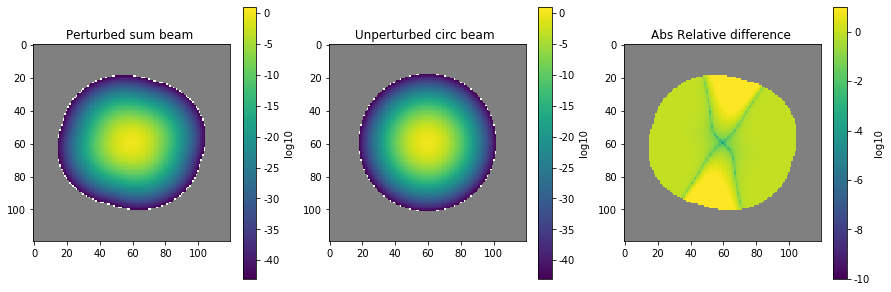

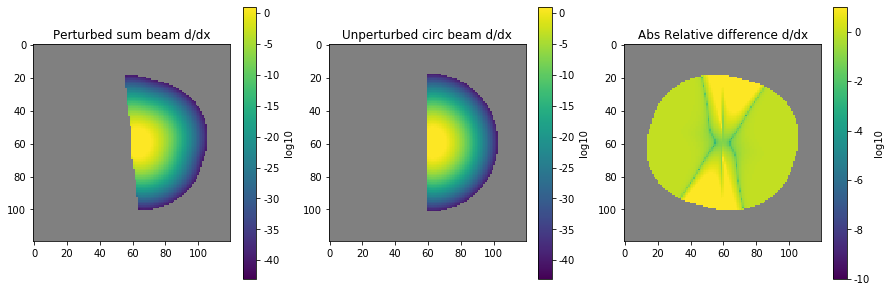

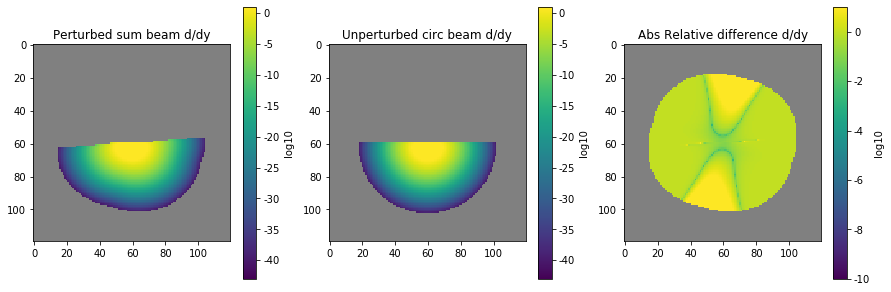

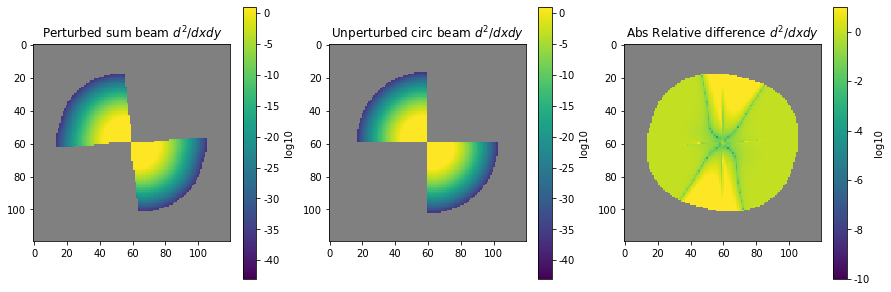

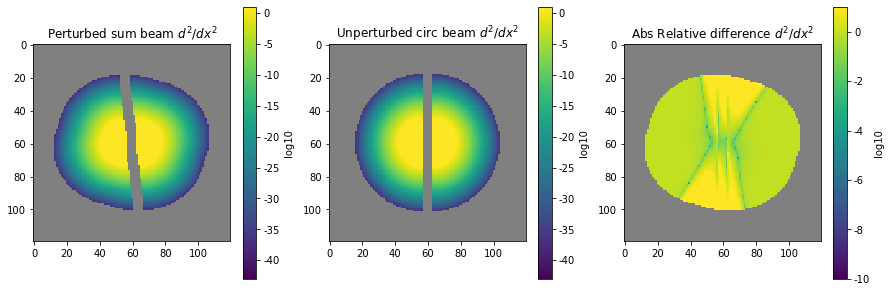

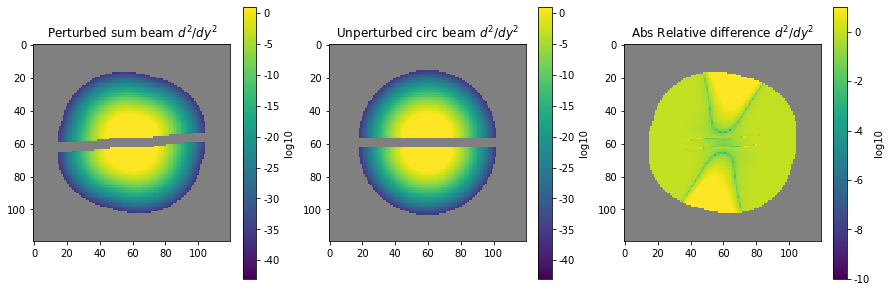

In [99]:
### this cells  shows a comparison between the derivatives of the sum beam (perturbed) and the derivative of the
### circular gaussian one used for the examples. 
### Developing the sum beam on the sum beam derivatives instead of the circular beam, should introduce minor 
### differences

## Visualisation setup
pix_size = 0.5 / 60. * np.pi / 180.
nx=120

# pair beams used for the example
ct=30
cb=31

# compute sum beam and its derivatives
summap, diffmap = construct_beammap(inst.beam_model, ct,cb, nx, pix_size)
der_sum = derivs(summap,pix_size=pix_size)


# compute circular Gaussian beam and its derivatives 
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam,pix_size=pix_size)
titles = ['','d/dx','d/dy','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(6):
    fig, ax = pl.subplots(1, 3, figsize=(15, 5))

    obj1=ax[0].imshow(np.log10(der_sum[i]), vmin=-43, vmax=1)
    ax[0].set_title('Perturbed sum beam %s'%titles[i])
    obj2=ax[1].imshow(np.log10(der_circ[i]), vmin=-43, vmax=1)
    ax[1].set_title('Unperturbed circ beam %s'%titles[i])
    obj3=ax[2].imshow(np.log10(np.abs(der_circ[i]/der_sum[i] -1)), vmin=-10, vmax=1)
    ax[2].set_title('Abs Relative difference %s'%titles[i])    
    fig.colorbar(obj1, ax=ax[0], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj2, ax=ax[1], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj3, ax=ax[2], orientation='vertical', shrink=1., format='%.0f',label='log10')
    pl.show()


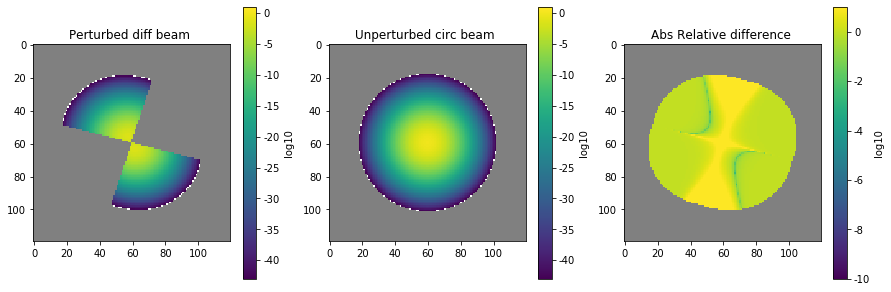

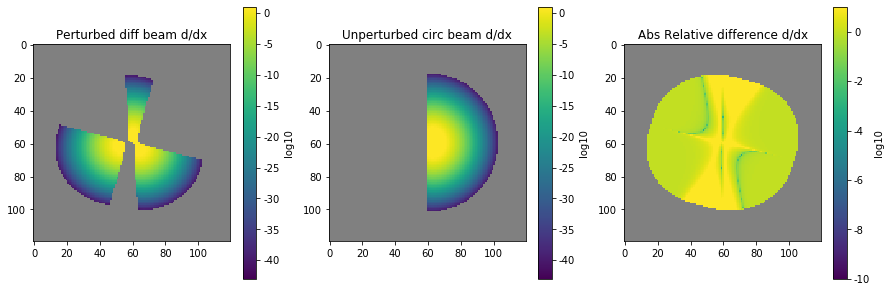

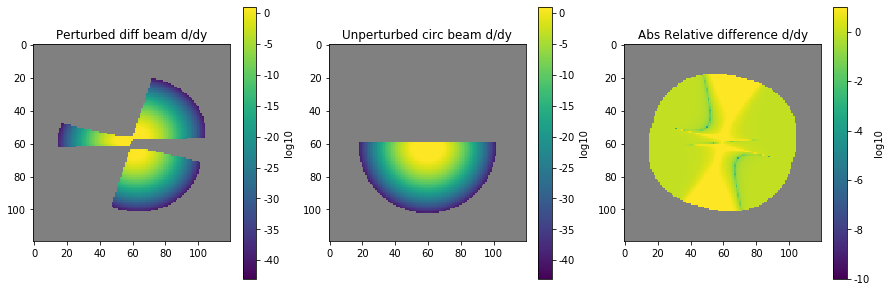

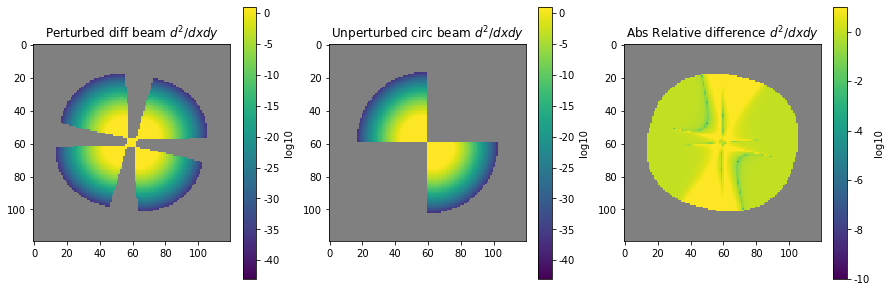

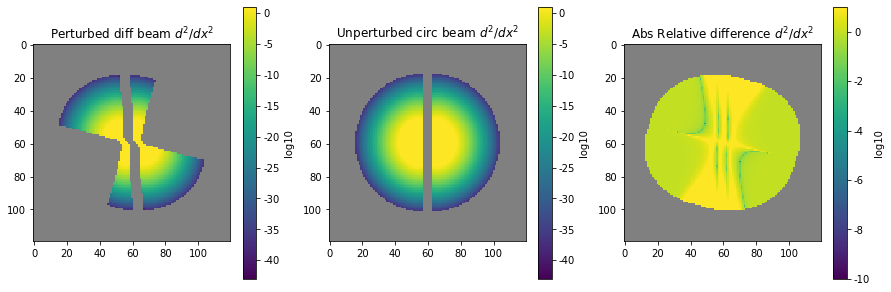

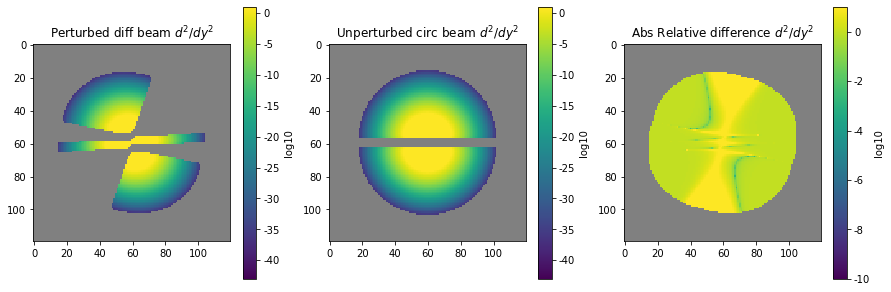

In [102]:
### same as previous cell for diff beam. Some part of the beam are cut because they are negative

## Visualisation setup
pix_size = 0.5 / 60. * np.pi / 180.
nx=120

# pair beams used for the example
ct=30
cb=31

# compute sum beam and its derivatives
summap, diffmap = construct_beammap(inst.beam_model, ct,cb, nx, pix_size)
der_diff= derivs(diffmap,pix_size=pix_size)


# compute circular Gaussian beam and its derivatives 
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam,pix_size=pix_size)
titles = ['','d/dx','d/dy','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(6):
    fig, ax = pl.subplots(1, 3, figsize=(15, 5))

    obj1=ax[0].imshow(np.log10(der_diff[i]), vmin=-43, vmax=1)
    ax[0].set_title('Perturbed diff beam %s'%titles[i])
    obj2=ax[1].imshow(np.log10(der_circ[i]), vmin=-43, vmax=1)
    ax[1].set_title('Unperturbed circ beam %s'%titles[i])
    obj3=ax[2].imshow(np.log10(np.abs(der_circ[i]/der_diff[i] -1)), vmin=-10, vmax=1)
    ax[2].set_title('Abs Relative difference %s'%titles[i])    
    fig.colorbar(obj1, ax=ax[0], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj2, ax=ax[1], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj3, ax=ax[2], orientation='vertical', shrink=1., format='%.0f',label='log10')
    pl.show()